# Convergence rates for Gaussian filters

In this notebook, we illustrate the usage of pn-diffeq through computing convergence rates of Gaussian ODE filters. See

https://arxiv.org/pdf/1807.09737.pdf

for analysis and many more experiments!

To illustrate, we use IVPs which allow a closed form solution. We start with the logistic ODE.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from probnum.diffeq import ode, odefiltsmooth
from probnum.prob import RandomVariable, Dirac


The logistic ODE as well as some others (Lotka-Volterra, FitzHugh-Nagumo, ...) are readily implemented in the `ode` module. To set them up, we need a random variable as initial values, e.g. a Dirac-distribution.

In [52]:
initdist = RandomVariable(distribution=Dirac(0.1 * np.ones(1)))
ivp1 = ode.logistic([0.0, 1], initdist)
arr = (np.array([ivp1.solution(0.) for i in range(2)]))


Solving IVPs is probably easiest with the function `filter_ivp_h()` where the ending `_h()` implies that we use constant step sizes. Adaptive steps are not ready for the public yet.

Note that the outputs contain estimates for the derivatives. To extract each coordinate, we slice accordingly.

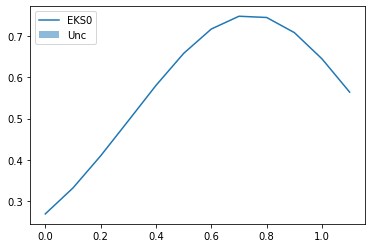

In [57]:
step = 0.1
ms, cs, ts = odefiltsmooth.filter_ivp_h(ivp1, step, which_prior="ibm1", which_filter="kf")
means = ms[:, 0]
means2 = ms[:, 1]
stdevs = np.sqrt(cs[:, 0, 0])
stdevs2 = np.sqrt(np.abs(cs[:, 1, 1]))
sols = np.array([ivp1.solution(t) for t in ts])
plt.plot(ts, means2, label="EKS0")
plt.fill_between(ts, means2-3*stdevs2, means2+3*stdevs2, alpha=0.5, label="Unc")
# plt.plot(ts, sols, alpha=0.25, linewidth=6, label="Truth")
plt.legend()
plt.show()

## Convergence rates of KF

We compare the convergence rates of the "classic" Kalman ODE filter on the IBM(1) prior. To this end, we comput the average error on each time step and the average standard deviation.

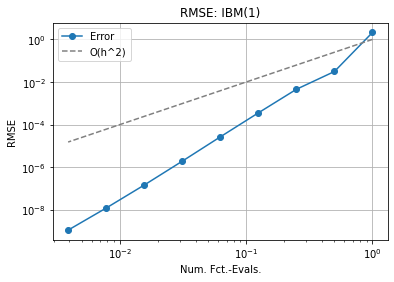

In [23]:
avgerr, avgstd = [], []
stps = np.array([0.5**i for i in range(9)])
for step in stps:
    ms, cs, ts = odefiltsmooth.smoother_ivp_h(ivp1, step, which_prior="ibm3")
    means = ms[:, 0]
    sols = np.array([ivp1.solution(t) for t in ts])
    # avgerr.append(np.linalg.norm(np.abs(sols[:, 0] - means))/np.sqrt(len(means)))
    avgerr.append(np.linalg.norm(sols[:, 0] - means, ord=np.inf))
plt.loglog(stps, avgerr, "o-", label="Error")
plt.loglog(stps, stps**2, "--", color="gray", label="O(h^2)")
plt.ylabel("RMSE")
plt.xlabel("Num. Fct.-Evals.")
plt.title("RMSE: IBM(1)")
plt.legend()
plt.grid()
plt.show()

## Higher order IBM(q) priors

Seems like IBM(1) does as expected. How do higher order IBM(q) priors fare? Note that only $q \in \{1, 2, 3\}$ is supported, since higher orders would require analytic knowledge of higher order derivatives of the ODE right-hand side function. 

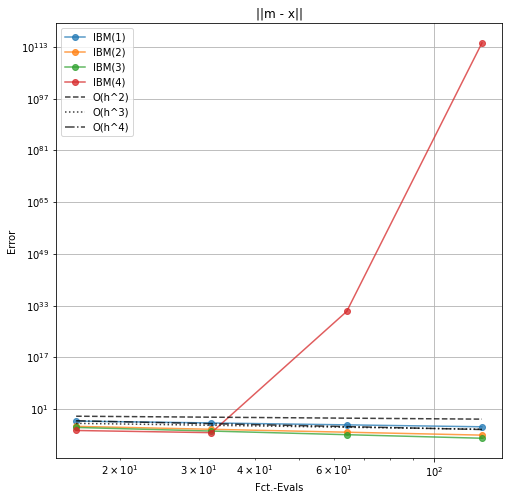

In [7]:
def error(ms, sols):
    return np.linalg.norm((sols[:, 0] - ms[:, 0]))/np.sqrt(sols[:, 0].size)

DCNST = 50
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
stps = np.array([0.5**i for i in range(4, 8)])

err_ibm1, err_ibm2, err_ibm3, err_ibm4 = [], [], [], []
for step in stps:
    ms1, __, ts1 = odefiltsmooth.smoother_ivp_h(ivp1, step, diffconst=DCNST, which_prior="ibm1", which_filt="kf")
    sols1 = np.array([ivp1.solution(t) for t in ts1])
    err_ibm1.append(error(ms1, sols1))
    
    ms2, __, ts2 = odefiltsmooth.smoother_ivp_h(ivp1, step, diffconst=DCNST, which_prior="ibm2", which_filt="kf")
    sols2 = np.array([ivp1.solution(t) for t in ts2])
    err_ibm2.append(error(ms2, sols2))
    
    ms3, __, ts3 = odefiltsmooth.smoother_ivp_h(ivp1, step, diffconst=DCNST, which_prior="ibm3", which_filt="kf")
    sols3 = np.array([ivp1.solution(t) for t in ts3])
    err_ibm3.append(error(ms3, sols3))

    
    ms4, __, ts4 = odefiltsmooth.smoother_ivp_h(ivp1, step, diffconst=DCNST, which_prior="ibm4", which_filt="kf")
    sols4 = np.array([ivp1.solution(t) for t in ts3])
    err_ibm4.append(error(ms4, sols4))

ax1.loglog(1/stps, np.array(err_ibm1), "o-", label="IBM(1)", alpha=0.75)
ax1.loglog(1/stps, np.array(err_ibm2), "o-", label="IBM(2)", alpha=0.75)
ax1.loglog(1/stps, np.array(err_ibm3), "o-", label="IBM(3)", alpha=0.75)
ax1.loglog(1/stps, np.array(err_ibm4), "o-", label="IBM(4)", alpha=0.75)

ax1.loglog(1/stps, stps**1, alpha=0.75, linestyle="--", color="black", label="O(h^2)")
ax1.loglog(1/stps, 0.1*stps**2, alpha=0.75, linestyle=":", color="black", label="O(h^3)")
ax1.loglog(1/stps, 10*stps**3, alpha=0.75, linestyle="-.", color="black", label="O(h^4)")
ax1.set_title("||m - x||")
ax1.set_xlabel("Fct.-Evals")
ax1.set_ylabel("Error")
ax1.legend()
ax1.grid()

plt.show()

## A Different ODE

The same results hold for a different ODE, e.g. for the linear system Eq. 8.3 in Kersting et al., 2019.

In [ ]:
def fct(t, x):
    x1, x2 = x
    return np.array([-np.pi*x2, np.pi*x1])

def jac(t, x):
    return np.array([[0, -np.pi],[np.pi, 0]])

def sol(t):
    return np.array([-np.sin(t*np.pi), np.cos(t*np.pi)])

initdist = gaussian.MultivariateGaussian(np.array([0., 1.]), 0*np.eye(2))
ivp_lin = ode.ivp.IVP([0., 5.], initdist, fct, jac=jac, sol=sol)


In [ ]:
def error(ms, sols):
    return np.linalg.norm((sols - ms))/np.sqrt(sols.size)

DCNST = 25
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
stps = np.array([0.5**i for i in range(4, 9)])

err_ibm1, err_ibm2, err_ibm3, err_ibm4 = [], [], [], []
for step in stps:
    ms1, __, ts1 = odefilter.solve_filter_h(ivp_lin, step, diffconst=DCNST, which_prior="ibm1", which_filt="kf")
    sols1 = np.array([ivp_lin.solution(t) for t in ts1])
    err_ibm1.append(error(ms1[:, [0, 2]], sols1))
    
    ms2, __, ts2 = odefilter.solve_filter_h(ivp_lin, step, diffconst=DCNST, which_prior="ibm2", which_filt="kf")
    sols2 = np.array([ivp_lin.solution(t) for t in ts2])
    err_ibm2.append(error(ms2[:, [0, 3]], sols2))
    
    ms3, __, ts3 = odefilter.solve_filter_h(ivp_lin, step, diffconst=DCNST, which_prior="ibm3", which_filt="kf")
    sols3 = np.array([ivp_lin.solution(t) for t in ts3])
    err_ibm3.append(error(ms3[:,  [0, 4]], sols3))

    # ms4, __, ts4 = odefilter.solve_filter_h(ivp, step, diffconst=DCNST, which_prior="ibm4", which_filt="kf")
    # sols4 = np.array([ivp.solution(t) for t in ts4])
    # err_ibm4.append(error(ms4, sols4))

ax1.loglog(1/stps, np.array(err_ibm1), "o-", label="IBM(1)", alpha=0.75)
ax1.loglog(1/stps, np.array(err_ibm2), "o-", label="IBM(2)", alpha=0.75)
ax1.loglog(1/stps, np.array(err_ibm3), "o-", label="IBM(3)", alpha=0.75)

ax1.loglog(1/stps, 20*stps**2, "--", alpha=0.75, color="gray", label="O(h^2)")
ax1.loglog(1/stps, 100*stps**3, "-.", alpha=0.75, color="gray", label="O(h^3)")
ax1.loglog(1/stps, 100*stps**4, ":", alpha=0.75, color="gray", label="O(h^4)")
ax1.set_title("||m - x||")
ax1.set_xlabel("Fct.-Evals")
ax1.set_ylabel("Error")
ax1.legend()
ax1.grid()

plt.show()

## Other Filters

We can do the same experiments for the UKF. Interestingly, it seems that the convergence rates somewhat hold in the same way, in fact they kick in much quicker, but numerical instability becomes a concern pretty quickly.

In [ ]:
def error(ms, sols):
    return np.linalg.norm((sols - ms))/np.sqrt(sols.size)

DCNST = 1
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
stps = np.array([0.5**i for i in range(1, 8)])

err_ibm1, err_ibm2, err_ibm3, err_ibm4 = [], [], [], []
for step in stps:
    ms1, __, ts1 = odefilter.solve_filter_h(ivp_lin, step, which_prior="ibm1", which_filt="ukf")
    sols1 = np.array([ivp_lin.solution(t) for t in ts1])
    err_ibm1.append(error(ms1[:, [0, 2]], sols1))
    
    ms2, __, ts2 = odefilter.solve_filter_h(ivp_lin, step, which_prior="ibm2", which_filt="ukf")
    sols2 = np.array([ivp_lin.solution(t) for t in ts2])
    err_ibm2.append(error(ms2[:, [0, 3]], sols2))
    
    ms3, __, ts3 = odefilter.solve_filter_h(ivp_lin, step, which_prior="ibm3", which_filt="ukf")
    sols3 = np.array([ivp_lin.solution(t) for t in ts3])
    err_ibm3.append(error(ms3[:,  [0, 4]], sols3))

    # ms4, __, ts4 = odefilter.solve_filter_h(ivp, step, diffconst=DCNST, which_prior="ibm4", which_filt="kf")
    # sols4 = np.array([ivp.solution(t) for t in ts4])
    # err_ibm4.append(error(ms4, sols4))

ax1.loglog(1/stps, np.array(err_ibm1), "o-", label="IBM(1)", alpha=0.75)
ax1.loglog(1/stps, np.array(err_ibm2), "o-", label="IBM(2)", alpha=0.75)
ax1.loglog(1/stps, np.array(err_ibm3), "o-", label="IBM(3)", alpha=0.75)

ax1.loglog(1/stps, 20*stps**2, "--", alpha=0.75, color="gray", label="O(h^2)")
ax1.loglog(1/stps, 1*stps**3, "-.", alpha=0.75, color="gray", label="O(h^3)")
ax1.loglog(1/stps, 10*stps**4, ":", alpha=0.75, color="gray", label="O(h^4)")
ax1.set_title("||m - x||")
ax1.set_xlabel("Fct.-Evals")
ax1.set_ylabel("Error")
ax1.legend()
ax1.grid()

plt.show()

In [ ]:
# This is for the IMPRS presentation, hence simplified labelling.

plt.rcParams.update({'font.size': 22})
def error(ms, sols):
    return np.linalg.norm((sols - ms))/np.sqrt(sols.size)

DCNST = 25
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
stps = np.array([0.5**i for i in range(3, 11)])

err_ibm1, err_ibm2, err_ibm3, err_ibm4 = [], [], [], []
for step in stps:
    ms1, __, ts1 = odefilter.solve_filter_h(ivp_lin, step, diffconst=DCNST, which_prior="ibm1", which_filt="kf")
    sols1 = np.array([ivp_lin.solution(t) for t in ts1])
    err_ibm1.append(error(ms1[:, [0, 2]], sols1))
    
    ms2, __, ts2 = odefilter.solve_filter_h(ivp_lin, step, diffconst=DCNST, which_prior="ibm2", which_filt="kf")
    sols2 = np.array([ivp_lin.solution(t) for t in ts2])
    err_ibm2.append(error(ms2[:, [0, 3]], sols2))
    
    ms3, __, ts3 = odefilter.solve_filter_h(ivp_lin, step, diffconst=DCNST, which_prior="ibm3", which_filt="kf")
    sols3 = np.array([ivp_lin.solution(t) for t in ts3])
    err_ibm3.append(error(ms3[:,  [0, 4]], sols3))

    # ms4, __, ts4 = odefilter.solve_filter_h(ivp, step, diffconst=DCNST, which_prior="ibm4", which_filt="kf")
    # sols4 = np.array([ivp.solution(t) for t in ts4])
    # err_ibm4.append(error(ms4, sols4))

ax1.loglog(1/stps, np.array(err_ibm1), "o-", label="Order 1", alpha=0.75, linewidth=3)
ax1.loglog(1/stps, np.array(err_ibm2), "o-", label="Order 2", alpha=0.75, linewidth=3)
ax1.loglog(1/stps, np.array(err_ibm3), "o-", label="Order 3", alpha=0.75, linewidth=3)

ax1.loglog(1/stps, 20*stps**2, "--", alpha=0.75, color="gray", label="O(h^2)", linewidth=2)
ax1.loglog(1/stps, 100*stps**3, "-.", alpha=0.75, color="gray", label="O(h^3)", linewidth=2)
ax1.loglog(1/stps, 100*stps**4, ":", alpha=0.75, color="gray", label="O(h^4)", linewidth=2)
ax1.set_xlabel("Fct.-Evals")
ax1.set_ylabel("Error")
ax1.legend()
ax1.grid()

plt.savefig("convrates_lin", dpi=300)
plt.show()